In [1]:
import os
os.chdir('../src')

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from datasets.load_d4ls import load_full_anndata
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
import time
from sklearn.model_selection import KFold

pd.set_option('display.max_columns', None)

In [3]:
def get_edge_index(pos, sample_ids, distance_thres):
    # construct edge indexes when there is region information
    edge_list = []
    sample_ids_unique = np.unique(sample_ids)
    for sample_id in sample_ids_unique:
        locs = np.where(sample_ids == sample_id)[0]
        pos_region = pos[locs, :]
        dists = pairwise_distances(pos_region)
        dists_mask = dists < distance_thres
        np.fill_diagonal(dists_mask, 0)
        region_edge_list = np.transpose(np.nonzero(dists_mask)).tolist()
        for i, j in region_edge_list:
            edge_list.append([locs[i], locs[j]])
    return edge_list

In [4]:
def get_train_test_masks(train_anndata, test_count=0):
    sample_ids = train_anndata.obs["sample_id"]
    sample_ids_unique = np.unique(sample_ids)

    sample_ids_idx = np.random.choice(np.arange(len(sample_ids_unique)), test_count, replace=False)
    test_sample_ids_mask = np.zeros_like(sample_ids_unique, dtype=bool)
    test_sample_ids_mask[sample_ids_idx] = True

    test_unique_sample_ids = sample_ids_unique[test_sample_ids_mask]

    test_mask = sample_ids.isin(test_unique_sample_ids)
    train_mask = ~test_mask

    return train_mask, test_mask

In [5]:
def prepare_data(train_anndata, make_graph=False, test_samples=10):
    train_mask, test_mask = get_train_test_masks(train_anndata, test_samples)

    X = train_anndata.layers['exprs']
    X_train = X[train_mask]
    X_test = X[test_mask]

    pos = train_anndata.obs[["Pos_X", "Pos_Y"]].values
    pos_train = pos[train_mask]
    pos_test = pos[test_mask]

    if make_graph:
        sample_ids = train_anndata.obs["sample_id"]
        test_sample_ids = sample_ids[test_mask]
        train_sample_ids = sample_ids[train_mask]

        edges_train = get_edge_index(pos_train, train_sample_ids, 10)
        edges_test = get_edge_index(pos_test, test_sample_ids, 10)
    else:
        edges_train = None
        edges_test = None

    cell_types = np.sort(list(set(train_anndata.obs["cell_labels"].values))).tolist()
    # we here map class in texts to categorical numbers and also save an inverse_dict to map the numbers back to texts
    cell_type_dict = {}
    inverse_dict = {}
    for i, cell_type in enumerate(cell_types):
        cell_type_dict[cell_type] = i
        inverse_dict[i] = cell_type
        
    Y_train = train_anndata.obs["cell_labels"].values[train_mask]
    Y_test = train_anndata.obs["cell_labels"].values[test_mask]

    Y_train = np.array([cell_type_dict[x] for x in Y_train])
    Y_test = np.array([cell_type_dict[x] for x in Y_test])

    return X_train, Y_train, edges_train, X_test, Y_test, edges_test, inverse_dict

In [45]:
train_anndata = load_full_anndata()

X_train, Y_train, edges_train, X_test, Y_test, edges_test, inverse_dict = prepare_data(train_anndata)

In [10]:
categories = train_anndata.obs["sample_id"].cat.remove_unused_categories()

In [15]:
kfold = KFold(n_splits=5, shuffle=True, random_state=124)
split = kfold.split(categories.cat.categories)
for train, test in split:
    print(train, test)

[  0   2   3   4   5   6   7   8   9  11  12  14  15  16  17  18  19  20
  21  22  25  27  28  30  31  33  35  36  37  38  39  40  41  42  43  45
  46  47  48  49  50  52  53  54  55  57  58  59  60  62  63  64  65  66
  67  69  70  71  72  73  74  75  77  78  79  81  85  86  88  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 113 114 116 118 119 120 121 122 123 124] [  1  10  13  23  24  26  29  32  34  44  51  56  61  68  76  80  82  83
  84  87  89  90 112 115 117]
[  1   2   4   7   8   9  10  12  13  14  16  17  18  20  21  23  24  25
  26  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44  46
  48  49  51  52  53  54  55  56  57  58  60  61  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  93  94  95 101 102 103 104 105 107 108 109 111 112
 113 114 115 116 117 118 119 120 123 124] [  0   3   5   6  11  15  19  22  27  35  45  47  50  59  62  92  96  97
  98  99 1

In [16]:
train_anndata.obs["sample_id"].isin(categories.cat.categories[[5]]).sum()

563

In [46]:
X_train.shape

(216657, 40)

In [56]:
Y_train.shape

(216657,)

In [57]:
Y_test

array([ 7, 11, 11, ..., 11,  3, 11])

In [66]:
torch.from_numpy(Y_train).shape

torch.Size([216657])

In [79]:
dataset = {}
dataset['train_input'] = torch.Tensor(X_train)
dataset['train_label'] = torch.Tensor(Y_train).long()
dataset['test_input'] = torch.Tensor(X_test)
dataset['test_label'] = torch.Tensor(Y_test).long()

In [80]:
dataset['train_input'].shape

torch.Size([216657, 40])

In [83]:
dataset['train_label'].unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [20]:
# scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)

In [84]:
from kan import *
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[40,14], grid=5, k=3, seed=0)

In [ ]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

results = model.train(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss());

description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

In [ ]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

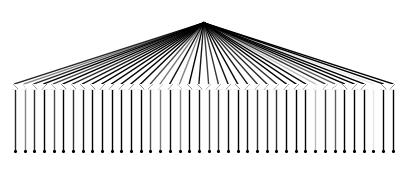

In [37]:
model(dataset['train_input']);
model.plot(beta=100)

In [ ]:
results['train_acc'][-1], results['test_acc'][-1]

In [ ]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]

In [ ]:
model.plot()

In [ ]:
model.prune()
model.plot(mask=True)

In [ ]:
model = model.prune()
model(X_train)
model.plot()

In [ ]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

In [ ]:
(Y_test == predicted).sum() / len(predicted)

In [ ]:
clf.coefs_

In [ ]:
clf.intercepts_[2]

In [ ]:
best_xgb_param_grid = {
    "n_estimators": [30, 40, 50],
    "max_depth": [3],
    "learning_rate": [0.3],
    'objective': ['multi:softmax']
}

xgb_grid_search = GridSearchCV(XGBClassifier(), param_grid=best_xgb_param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=3)

In [ ]:
xgb_grid_search.fit(X_train_scaled, Y_train)

In [ ]:
pd.DataFrame(xgb_grid_search.cv_results_)

In [ ]:
class MLP(nn.Module):
    def __init__(self):
      super().__init__()
      self.layers = nn.Sequential(
        nn.Linear(40, 40*4),
        nn.ReLU(),
        nn.Linear(40*4, 40*4),
        nn.ReLU(),
        nn.Linear(40*4, 14),
        # nn.Softmax(dim=1)
      )
    def forward(self, input):
       return self.layers(input)

In [ ]:
# train config

max_epochs=42
device = torch.device("cpu")

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X_train, Y_train):
        self.X_train = X_train
        self.Y_train = Y_train
        
    def __len__(self):
        return len(self.X_train)
    
    def __getitem__(self, idx):
        return self.X_train[idx], self.Y_train[idx]


x_train, X_val, y_train, y_val = train_test_split(torch.tensor(X_train).float(), torch.tensor(Y_train).long(), test_size=0.1, random_state=42)

# Create CustomDataset instance
train_dataset = CustomDataset(x_train, y_train)
# val_dataset = CustomDataset(X_val, y_val)

# Create DataLoader
batch_size = 200
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def compute_accuracy(model, X_val, y_val):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # No need to compute gradients during validation
        pred = model(X_val)
        correct = (torch.argmax(pred, dim=1) == y_val).float().sum()
        accuracy = correct / len(y_val)

    return accuracy

In [ ]:
model = MLP()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

model.train()
start = time.time()

best_val_acc = 0.
best_model_weights = None

train_losses = []
val_acc = []

for epoch in range(max_epochs):

    total_loss = 0.
    total_acc = 0.
    printevery = 5

    print("\r   %dm: epoch %d [%s] %d%%  loss = %s" %\
    ((time.time() - start)//60, epoch + 1, "".join(' '*20), 0, '...'), end='')


    for i, (input, targets) in enumerate(train_data_loader):
        input, targets = input.to(device), targets.to(device)

        optimizer.zero_grad()
        pred = model(input)
        loss = criterion(pred, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (i + 1) % printevery == 0:
                p = int(100 * (i + 1) / len(train_data_loader))
                avg_loss = total_loss / printevery

                print("\r   %dm: epoch %d [%s%s] %d%% train loss = %.10f" %\
                ((time.time() - start)//60, epoch + 1, "".join('#'*(p//5)), "".join(' '*(20-(p//5))), p, avg_loss), end='')

                train_losses.append(avg_loss)
                total_loss = 0.
                total_acc = 0.

    val_accuracy = compute_accuracy(model, X_val, y_val)
    val_acc.append(val_accuracy)
    if best_val_acc < val_accuracy:
        best_model_weights = model.state_dict()

    print("\r%dm: epoch %d [%s%s] %d%% \nepoch %d complete, val acc = %.10f" %\
    ((time.time() - start)//60, epoch + 1, "".join('#'*(100//5)), "".join(' '*(20-(100//5))), 100, epoch + 1, val_accuracy))

model.load_state_dict(best_model_weights)

In [ ]:
model.load_state_dict(best_model_weights)

In [ ]:
compute_accuracy(model, torch.tensor(X_test).float(), torch.tensor(Y_test).long())

In [ ]:
model_from_sklearn = MLP()

In [ ]:
state_dict = model_from_sklearn.state_dict()

In [ ]:
torch.tensor(clf.coefs_[0]).float().shape

In [ ]:
torch.tensor(clf.intercepts_[0]).float().shape

In [ ]:
state_dict["layers.0.weight"].shape

In [ ]:
state_dict["layers.0.bias"].shape

In [ ]:
for i in range(len(clf.coefs_)):
    state_dict[f"layers.{2*i}.weight"] = torch.tensor(clf.coefs_[i]).float().t()
for i in range(len(clf.intercepts_)):
    state_dict[f"layers.{2*i}.bias"] = torch.tensor(clf.intercepts_[i]).float()

In [ ]:
model_from_sklearn.load_state_dict(state_dict)

In [ ]:
compute_accuracy(model_from_sklearn, torch.tensor(X_test).float(), torch.tensor(Y_test).long())